In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize

import statsmodels.formula.api as smf # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
ADS_DATAPATH = 'data/ads.csv'
CURRENCY_DATAPATH = 'data/currency.csv'

## Visualize data

In [6]:
ads = pd.read_csv(ADS_DATAPATH, index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv(CURRENCY_DATAPATH, index_col=['Time'], parse_dates=['Time'])

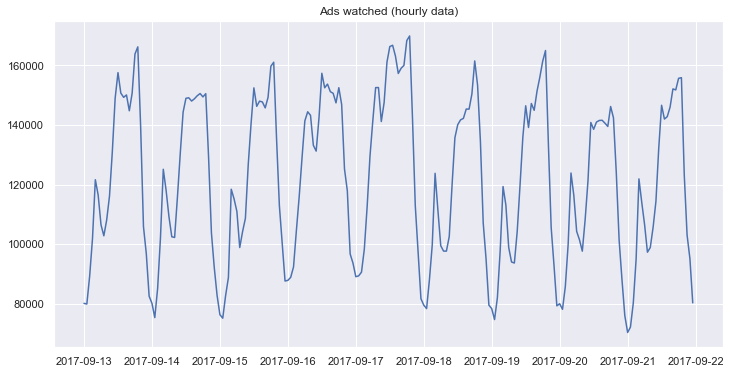

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

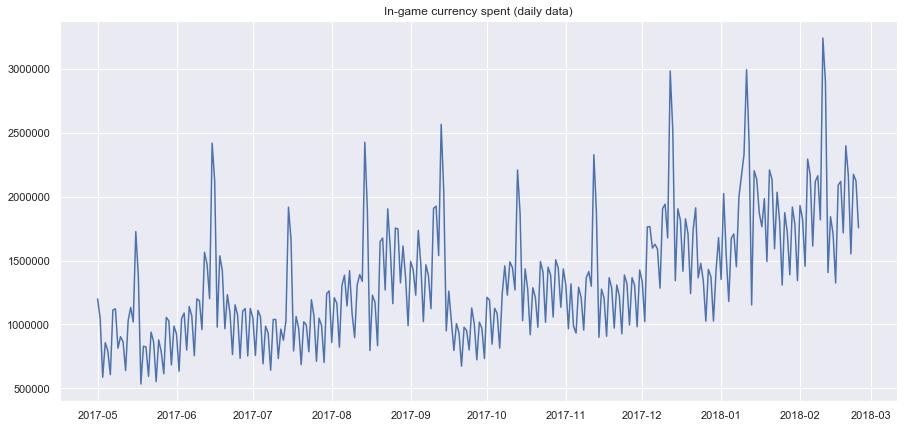

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(currency)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

## Import error metrics

In [11]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Moving average

Assume that the future value of the target depends on the average of its *k* previous values. 

This is called **moving average** .

In [16]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    
    return np.average(series[-n:])

#Prediction for the last observed day (past 24h)
moving_average(ads, 24)

116805.0

We cannot make predictions far in the future - in order to get the value for the next step, we need the previous values to be actually observed. However, moving average can *smooth* the original time series to identify trends. In the case of very noisy data, which is often encountered in finance, this procedure can hepl detect common patterns.

In [19]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with time series
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
        #Having confidence intervals for smoothed value
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bound] = series[series < lower_bound]
            anomalies[series > upper_bound] = series[series > upper_bound]
            plt.plot(anomalies, 'ro', markersize=10)
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='upper left')
    plt.grid(True)

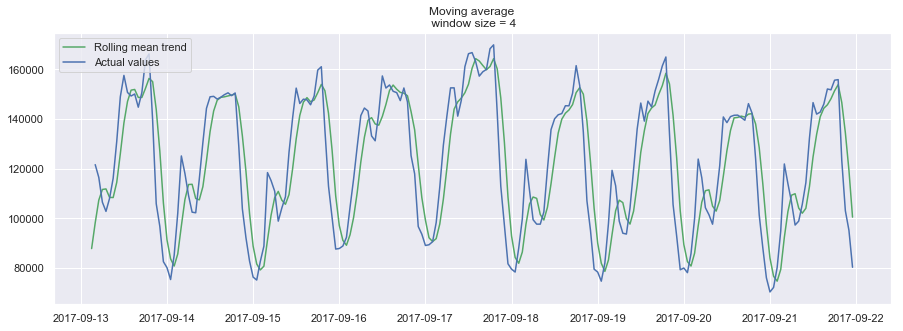

In [20]:
#Smooth by the previous 4 hours
plot_moving_average(ads, 4)

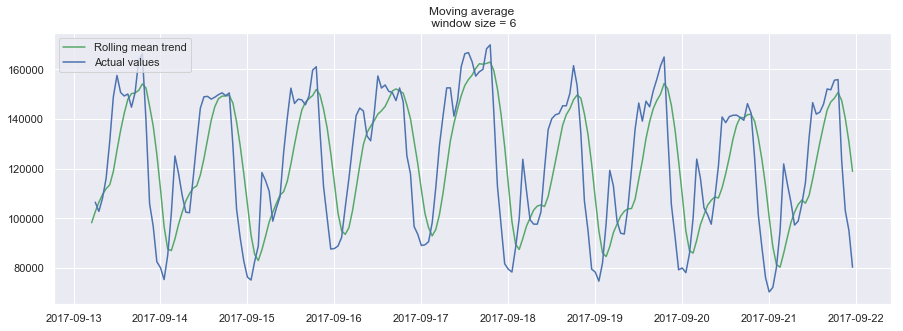

In [24]:
#Smooth by the previous 6 hours
plot_moving_average(ads, 6)

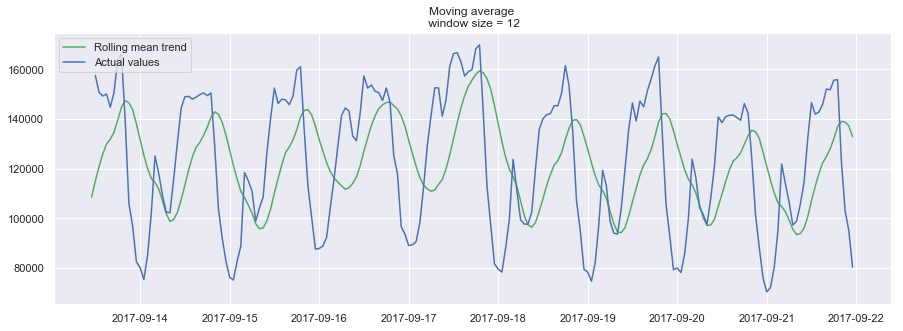

In [21]:
#Smooth by previous 12 hours
plot_moving_average(ads, 12)

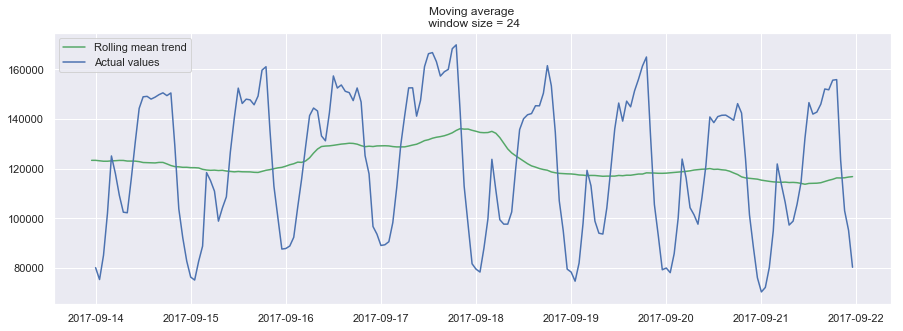

In [22]:
#Smooth by previous 24h (daily trend)
plot_moving_average(ads, 24)

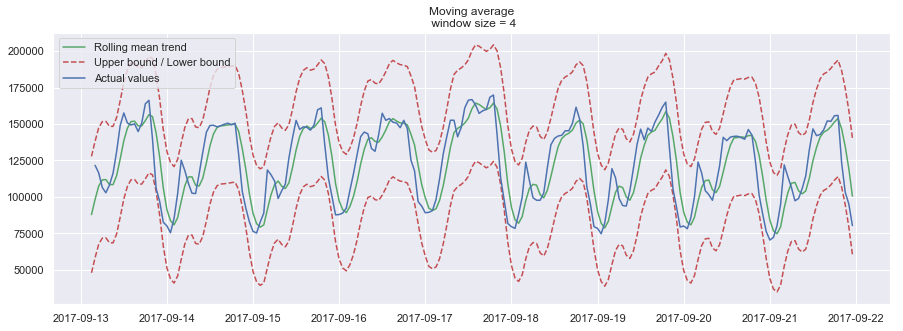

In [25]:
plot_moving_average(ads, 4, plot_intervals=True)

Create anomalies to check if the method can catch anomalies

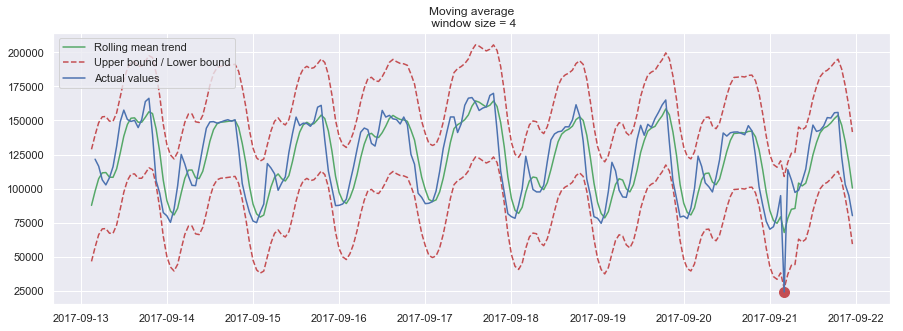

In [26]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2

plot_moving_average(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

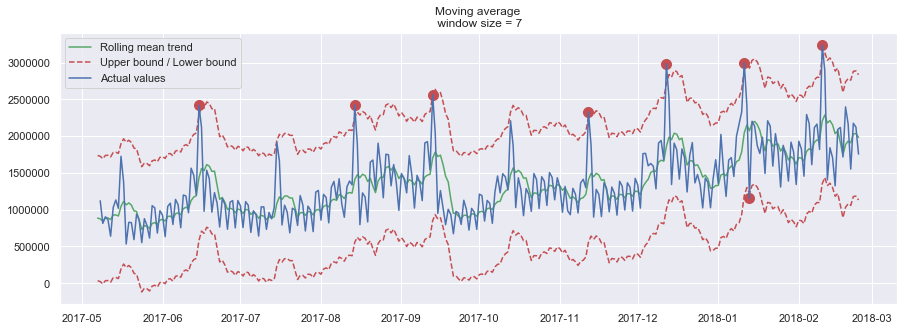

In [27]:
plot_moving_average(currency, 7, plot_intervals=True, plot_anomalies=True)# weekly smoothing

Above, the method is not robust enough, because it failed to find the monthly seasonality of the data and it identified all peaks as anomalies. Therefore, we need more complex models.

**Weighted average** is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.

In [30]:
def weighted_average(series, weights):
    """
        Calculate weighted average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)

In [32]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

## Exponential smoothing

Exponential smoothing takes all *k* values, and assigns weights to them. However, the weights exponentially decrease as we move further back in time. 

A smoothing factor defines how quickly we "forget" the last available true observation. The smaller it is, the more influence the previous observations have, and the smoother the series is.

In [42]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [43]:
def plot_exponential_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

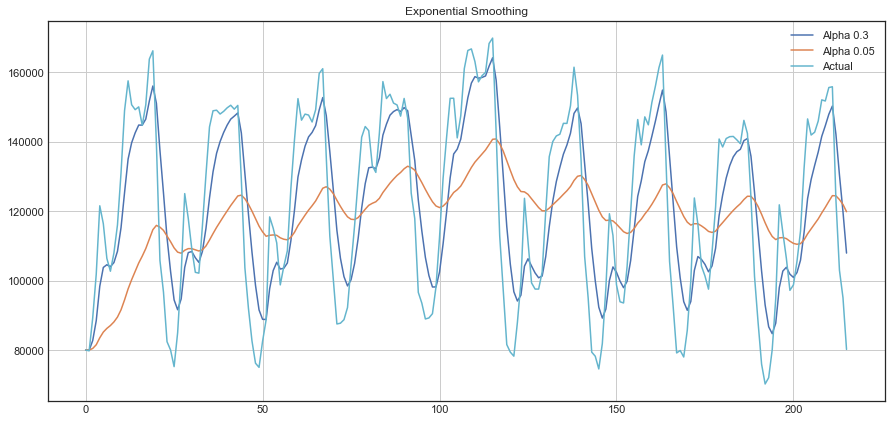

In [46]:
plot_exponential_smoothing(ads.Ads, [0.3, 0.05])

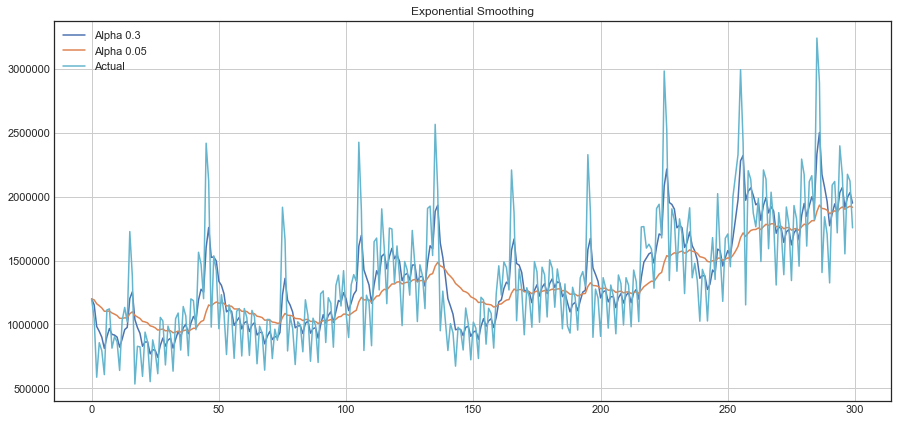

In [49]:
plot_exponential_smoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

## Double exponential smoothing

Now, we apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depending on the previous weighted changes.

In [50]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [51]:
def plot_double_exponential_smoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

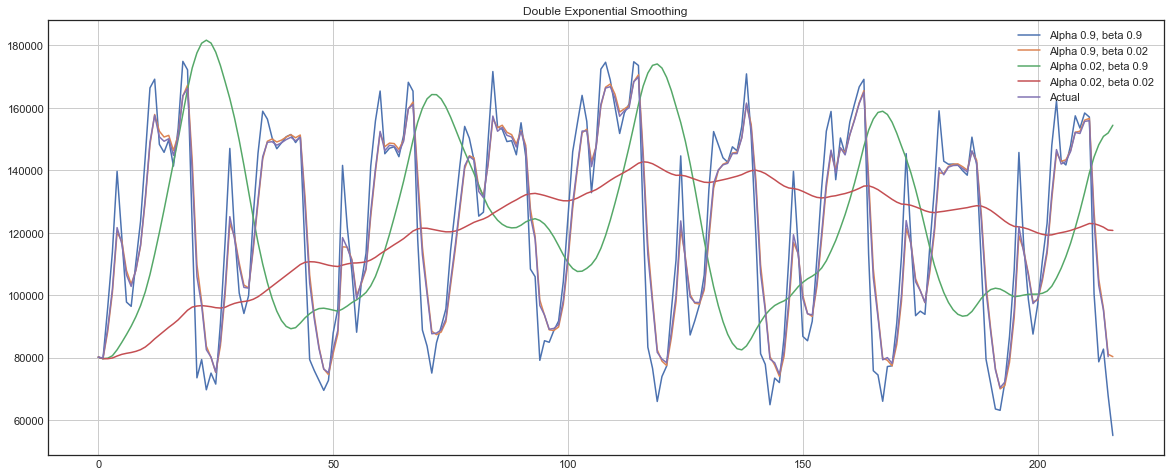

In [53]:
plot_double_exponential_smoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

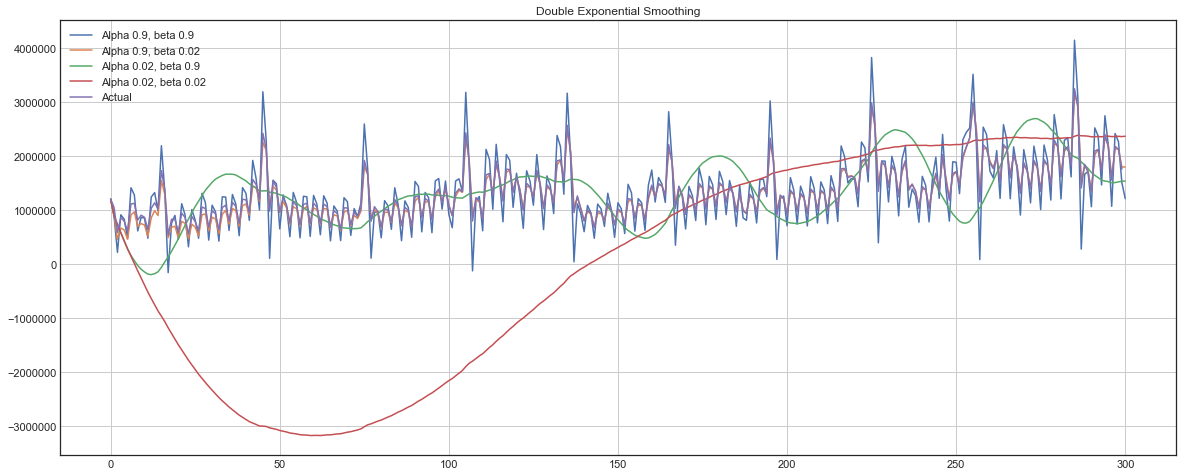

In [54]:
plot_double_exponential_smoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])